In [1]:
import numpy as np
import torch
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob

In [2]:
# Rearranges matrix into a column vector

def im2col(image, block_size = (1,1), skip=1):

    rows, cols = image.shape
    vert_blocks = rows - block_size[0] + 1

    output_vectors = np.zeros((block_size[0] * block_size[1], cols * rows))
    itr = 0
    for row in range(rows):
        for col in range(cols):
            output_vectors[:, itr] = image[row: row + block_size[0], col: col + 1].ravel()
            itr += 1

    return output_vectors[:, ::skip]

# Performs function of Fig2 (left), creates data matrix X, and outputs the covariance of this matrix. 
# Requires input of ONE CHANNEL, not RGB

def one_channel_to_cov(image, filter_size):
    x, y = filter_size
    H, W = image.shape
    X = [0]*(x*y)
    for i in range(x):
        for j in range(y):
            
            X[y*i + j] = im2col(np.array(image[i:W+i-x+1, j:H+j-y+1]), )


    X = np.squeeze(np.asarray(X)).T

    u = np.mean(X)
    N = X.shape[0]

    X = (X-u).T @ X
    Cov = X / N
    
    return Cov

# This function is provided in the Network Deconvolution paper.
# Numerical approximation of inverse sqrt. Used to invertsqrt the Cov matrix to get Deconv matrix D.

def isqrt_newton_schulz_autograd(A, numIters):
    dim = A.shape[0]
    normA=A.norm()
    Y = A.div(normA)
    I = torch.eye(dim,dtype=A.dtype,device=A.device)
    Z = torch.eye(dim,dtype=A.dtype,device=A.device)

    for i in range(numIters):
        T = 0.5*(3.0*I - Z@Y)
        Y = Y@T
        Z = T@Z
    #A_sqrt = Y*torch.sqrt(normA)
    A_isqrt = Z / torch.sqrt(normA)
    return A_isqrt

# plot kernel in 3D
def plot_3D(ker):
    # Set up grid and test data
    nx, ny = 15, 15
    x = range(nx)
    y = range(ny)

    hf = plt.figure()
    ha = hf.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(x, y)  
    ha.plot_surface(X, Y, np.reshape(ker, (15,15)))

    plt.show()

################
# Executes above functions to take ONE CHANNEL input, return kernel (as a vector)

def channel_to_kernel(image, k):
  # Data Matrix X
    cov = one_channel_to_cov(image, (k, k))

    # Deconv matrix D is equal to inverse sqrt of cov matrix. 
    D = isqrt_newton_schulz_autograd(torch.Tensor(cov), 10)

    
    # Extract kernel from Deconv matrix
    ker = torch.diagonal(D)

    return ker


In [3]:
#SET FILTER SIZE
k = 15

In [4]:
# im_name must be string ending in .jpeg

def load_image(im_name, rows, cols, channels):
    #load image
    image = Image.open(im_name)
    # convert image to numpy array
    data = asarray(image)

    data_square = data
    #Resize to square, reduce size for computational efficiency
    data_square = np.resize(data_square, (rows, cols, channels))

    
    return data_square

In [5]:
# ImageNet 128 is a local folder containing 128 randomly selected JPEG images from ImageNet
filenames = glob.glob("/Users/elliotstein/Documents/Semester 2/Deep Learning/ImageNet 128/*.JPEG")

In [7]:
# Create dictionary storing all images
# Each image is formatted by the load_image function, stored under name data1, data2 etc.
d = {}
N = len(filenames)
for x in range(N):
    d["data{0}".format(x)] = load_image(filenames[x], 224, 224, 3)
    
    
RGB = ['Red', 'Green', 'Blue']
for i in range(3):
    # Reset and initialise ker variable for storing kernel
    ker = None
    ker = torch.zeros((k,k))    
    
    for x in range(N):
        print(RGB[i], ': ', x, "/", N)
        
        
        # Takes individual RGB channel from image, creates deconvolutional kernel and adds to ker
        ker+=torch.Tensor(channel_to_kernel(d["data{0}".format(5)][:,:,i], k)).reshape(15,15)
             
        # Stores three variables, one for each of the RGB channels. Each is the average over all image 
        # deconvolutional kernels
    if i == 0:
        ker0 = ker/N
    if i == 1:
        ker1 = ker/N
    if i == 0:
        ker2 = ker/N

Red :  0 / 128
Red :  1 / 128
Red :  2 / 128
Red :  3 / 128
Red :  4 / 128
Red :  5 / 128
Red :  6 / 128
Red :  7 / 128
Red :  8 / 128
Red :  9 / 128
Red :  10 / 128
Red :  11 / 128
Red :  12 / 128
Red :  13 / 128
Red :  14 / 128
Red :  15 / 128
Red :  16 / 128
Red :  17 / 128
Red :  18 / 128
Red :  19 / 128
Red :  20 / 128
Red :  21 / 128
Red :  22 / 128
Red :  23 / 128
Red :  24 / 128
Red :  25 / 128
Red :  26 / 128
Red :  27 / 128
Red :  28 / 128
Red :  29 / 128
Red :  30 / 128
Red :  31 / 128
Red :  32 / 128
Red :  33 / 128
Red :  34 / 128
Red :  35 / 128
Red :  36 / 128
Red :  37 / 128
Red :  38 / 128
Red :  39 / 128
Red :  40 / 128
Red :  41 / 128
Red :  42 / 128
Red :  43 / 128
Red :  44 / 128
Red :  45 / 128
Red :  46 / 128
Red :  47 / 128
Red :  48 / 128
Red :  49 / 128
Red :  50 / 128
Red :  51 / 128
Red :  52 / 128
Red :  53 / 128
Red :  54 / 128
Red :  55 / 128
Red :  56 / 128
Red :  57 / 128
Red :  58 / 128
Red :  59 / 128
Red :  60 / 128
Red :  61 / 128
Red :  62 / 128
Re

Red Channel Deconv Kernel


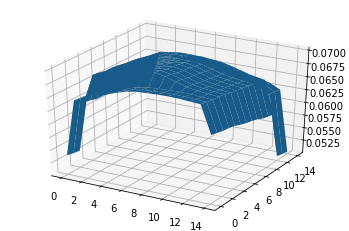

Green Channel Deconv Kernel


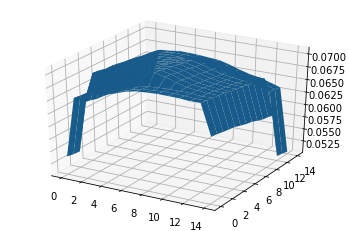

Blue Channel Deconv Kernel


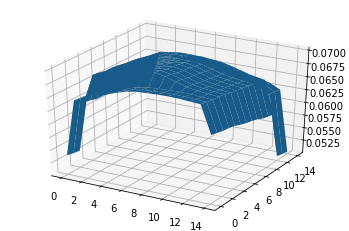

In [8]:
print('Red Channel Deconv Kernel')
plot_3D(np.array(ker0))
print('Green Channel Deconv Kernel')
plot_3D(np.array(ker1))
print('Blue Channel Deconv Kernel')
plot_3D(np.array(ker2))